In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [3]:
stock = 'AAPL'
start_date = '2019-01-01'
end_date = '2024-01-01'
data = yf.download(stock,start_date,end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845047,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530052,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126774,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700


In [4]:
for col in data.columns:
    data[col] = data[col].fillna(data[col].ffill().mean()).fillna(0)

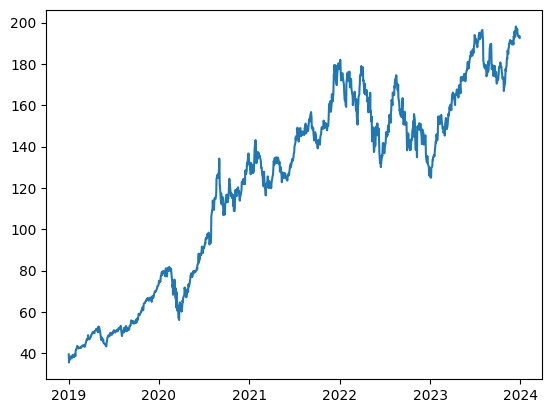

In [5]:
plt.plot(data['Close'])

## Technical Indicators Calculation

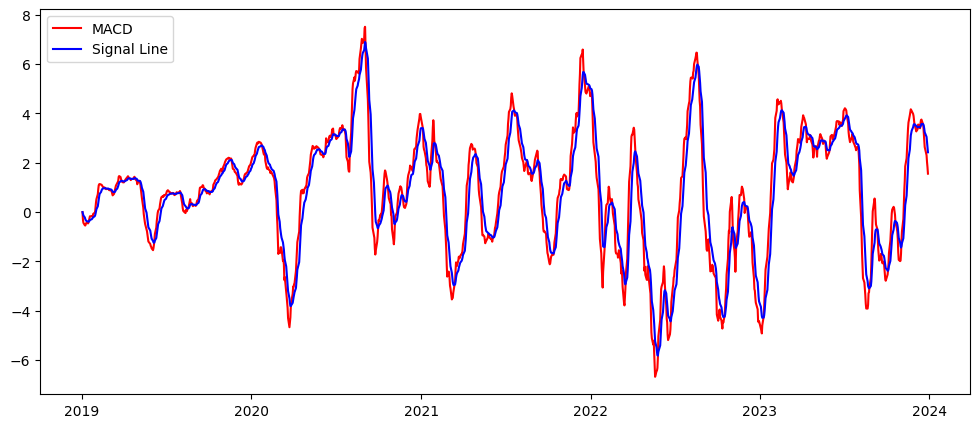

In [6]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short-term and long-term exponential moving averages
    data['ShortEMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    data['MACD'] = data['ShortEMA'] - data['LongEMA']

    # Calculate signal line
    data['Signal_MACD'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

data = calculate_macd(data)

def plot_macd(data):
    plt.figure(figsize=(12,5))
    plt.plot(data.index, data['MACD'], label='MACD', color = 'red')
    plt.plot(data.index, data['Signal_MACD'], label='Signal Line', color='blue')
    plt.legend(loc='upper left')
    plt.show()

plot_macd(data)

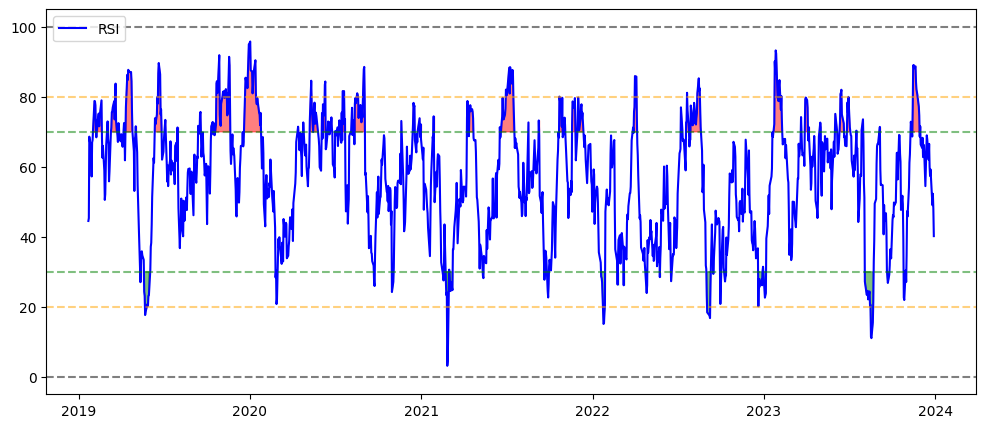

In [7]:
def calculate_rsi(data, window=14):
    price_change = data['Close'].diff(1)

    up_prices = price_change.where(price_change > 0, 0)
    down_prices = price_change.where(price_change < 0, 0)

    avg_gain = up_prices.rolling(window).mean()
    avg_loss = down_prices.abs().rolling(window).mean()

    rsi = 100 - (100 / (1 + (avg_gain/avg_loss)))
    data['RSI'] = rsi
    return data

data = calculate_rsi(data)

def plot_rsi(data):
    plt.figure(figsize=(12,5))
    plt.plot(data.index, data['RSI'], label='RSI', color = 'blue')
    plt.axhline(0, linestyle='--', alpha=0.5, color='black')
    plt.axhline(20, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.axhline(70, linestyle='--', alpha=0.5, color='green')
    plt.axhline(80, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5, color='black')
    plt.fill_between(data.index, data['RSI'], 70, where=(data['RSI'] >= 70), color='red', alpha=0.5)
    plt.fill_between(data.index, data['RSI'], 30, where=(data['RSI'] <= 30), color='green', alpha=0.5)
    plt.legend(loc='upper left')
    plt.show()

plot_rsi(data)

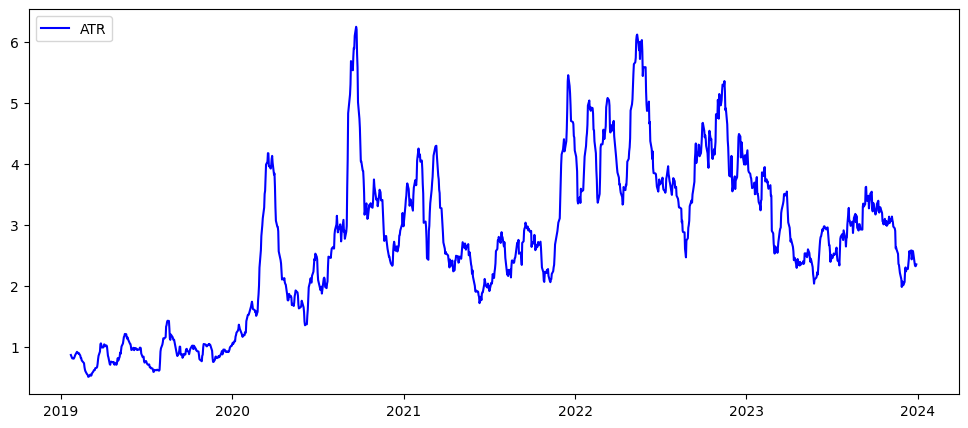

In [8]:
def calculate_average_true_range(data, period=14):
    data['TR'] = data.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Close']), abs(row['Low'] - row['Close'])), axis=1)
    data['ATR'] = data['TR'].rolling(period).mean()
    return data

data = calculate_average_true_range(data)

def plot_atr(data):
    plt.figure(figsize=(12,5))
    plt.plot(data.index, data['ATR'], label='ATR', color = 'blue')
    plt.legend(loc='upper left')
    plt.show()

plot_atr(data)

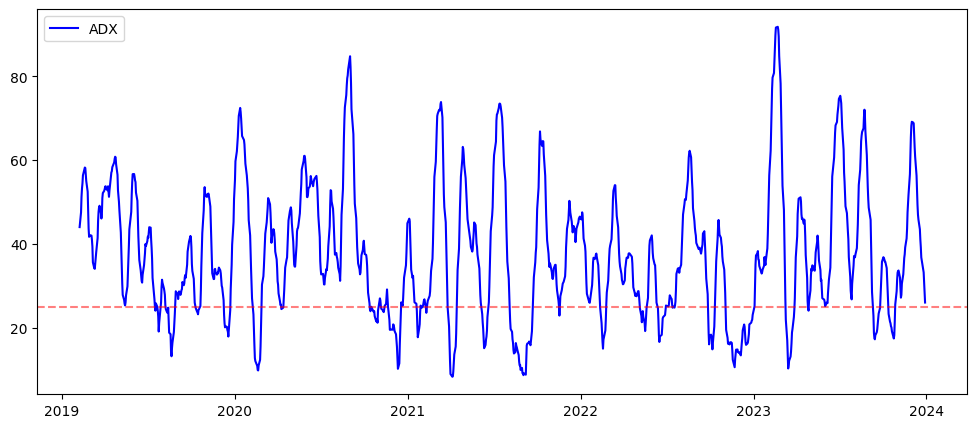

In [9]:
def calculate_adx(data, period=14):
    df = data.copy()
    df['High-Low'] = df['High'] - df['Low']
    df['High-PreviousClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PreviousClose'] = abs(df['Low'] - df['Close'].shift(1))

    df['TR'] = df[['High-Low', 'High-PreviousClose', 'Low-PreviousClose']].max(axis=1)

    df['+DM'] = 0.0
    df['-DM'] = 0.0

    df['High-PreviousHigh'] = df['High'].diff()
    df['Low-PreviousLow'] = -df['Low'].diff()

    df.loc[df['High-PreviousHigh'] > df['Low-PreviousLow'], '+DM'] = df['High-PreviousHigh']
    df.loc[df['High-PreviousHigh'] < df['Low-PreviousLow'], '-DM'] = df['Low-PreviousLow']

    df['Smoothed_TR'] = df['TR'].rolling(window=period).mean()
    df['Smoothed_+DM'] = df['+DM'].rolling(window=period).mean()
    df['Smoothed_-DM'] = df['-DM'].rolling(window=period).mean()

    df['+DI'] = (df['Smoothed_+DM'] / df['Smoothed_TR']) * 100
    df['-DI'] = (df['Smoothed_-DM'] / df['Smoothed_TR']) * 100

    df['DX'] = (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df['ADX']

data['ADX'] = calculate_adx(data)

def plot_adx(data):
    plt.figure(figsize=(12,5))
    plt.plot(data.index, data['ADX'], label='ADX', color = 'blue')
    plt.axhline(25, linestyle='--', alpha=0.5, color='red')
    plt.legend(loc='upper left')
    plt.show()

plot_adx(data)

In [10]:
def calculate_keltner_channel(data, period=20, multiplier=2):
    df = data.copy()
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Calculate ATR
    df['TR'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Close']), abs(row['Low'] - row['Close'])), axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Calculate upper and lower bands
    df['Upper_Keltner_Channel'] = df['Typical_Price'].ewm(span=period).mean() + multiplier * df['ATR']
    df['Lower_Keltner_Channel'] = df['Typical_Price'].ewm(span=period).mean() - multiplier * df['ATR']

    return df[['Upper_Keltner_Channel', 'Lower_Keltner_Channel']]

keltner_channel = calculate_keltner_channel(data)
data = pd.concat([data, keltner_channel], axis=1)

In [11]:
def calculate_bollinger_bands(data, window=20, num_std=2):
    df = data.copy()
    df['MA'] = df['Close'].rolling(window=window).mean()
    df['Std'] = df['Close'].rolling(window=window).std()

    df['Upper_Bollinger_Band'] = df['MA'] + (df['Std'] * num_std)
    df['Lower_Bollinger_Band'] = df['MA'] - (df['Std'] * num_std)

    return df[['Upper_Bollinger_Band', 'Lower_Bollinger_Band']]

bollinger_bands = calculate_bollinger_bands(data)
data = pd.concat([data, bollinger_bands], axis=1)

In [12]:
def calculate_bar_strength(data, span=5):

    # Calculate the upward price movement, representing the difference between closing price and lowest price
    data['Upward_price_movement'] = data['Close'] - data['Low']

    # Calculate the candle length, representing the difference between high and low prices
    data['Candle_length'] = data['High'] - data['Low']

    # Calculate Intraday bar Strength (IBS) as the ratio of upward price movement to candle length
    data['IBS'] = data['Upward_price_movement'] / data['Candle_length']

    # Calculate Weighted Moving Average of IBS
    data['weight_bar_strength'] = data['IBS'].ewm(span=span, adjust=False).mean()

    return data

data = calculate_bar_strength(data)

In [13]:
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    df = data.copy()

    # Calculate %K
    df['L14'] = df['Low'].rolling(window=k_period).min()
    df['H14'] = df['High'].rolling(window=k_period).max()
    df['%K'] = ((df['Close'] - df['L14']) / (df['H14'] - df['L14'])) * 100

    # Calculate %D
    df['%D'] = df['%K'].rolling(window=d_period).mean()

    return df[['%K', '%D']]

stochastic_oscillator = calculate_stochastic_oscillator(data)
data = pd.concat([data, stochastic_oscillator], axis=1)

In [14]:
def calculate_williams_oscillator(data, period = 16):
  highest_h = data['High'].rolling(period).max()
  lowest_l = data['Low'].rolling(period).min()

  williams=((highest_h-data['Close'])/(highest_h-lowest_l))*(-100)

  return williams

data['Williams_%R'] = calculate_williams_oscillator(data)

In [15]:
def calculate_ha_candles(data):
    ha_data = data.copy()

    # Calculate HA close
    ha_data['HA_Close'] = (ha_data['Open'] + ha_data['High'] + ha_data['Low'] + ha_data['Close']) / 4

    # Calculate HA open
    ha_data['HA_Open'] = (ha_data['Open'].shift(1) + ha_data['Close'].shift(1)) / 2

    # Calculate HA high
    ha_data['HA_High'] = ha_data[['HA_Open', 'HA_Close', 'High']].max(axis=1)

    # Calculate HA low
    ha_data['HA_Low'] = ha_data[['HA_Open', 'HA_Close', 'Low']].min(axis=1)

    # Drop the first row since it will have NaN values
    ha_data = ha_data.dropna()

    return ha_data[['HA_Open', 'HA_High', 'HA_Low', 'HA_Close']]

ha_candles = calculate_ha_candles(data)

In [16]:
def generate_target_variable(data):
    signals = []
    for i in range(len(data)-1):
        if data['Close'][i+1] > data['Close'][i]:
            signals.append(1)
        else:
            signals.append(-1)
    signals.append(1)
    return signals

data['signals'] = generate_target_variable(data)

In [17]:
for col in data.columns:
    data[col] = data[col].fillna(data[col].ffill().mean()).fillna(0)

In [18]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Extract features (technical indicators)
features = data.drop(columns=['signals'])

# Target variable
target = data['signals']

# Apply SelectKBest
k = 15  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(features, target)

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Retrieve the names of the selected features
selected_feature_names = features.columns[selected_indices]

In [19]:
print(selected_feature_names)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'ShortEMA', 'LongEMA',
       'ATR', 'Upper_Keltner_Channel', 'Lower_Keltner_Channel',
       'Upper_Bollinger_Band', 'Lower_Bollinger_Band', 'Upward_price_movement',
       'Candle_length', 'weight_bar_strength'],
      dtype='object')


In [20]:
import sqlite3

df = pd.DataFrame(selected_features, columns=selected_feature_names)

engine = sqlite3.connect('features.db')
df.to_sql('features', con=engine, if_exists='replace')
engine.close()

In [21]:
data

,Open,High,Low,Close,Adj Close,Volume,ShortEMA,LongEMA,MACD,Signal_MACD,...,Upper_Bollinger_Band,Lower_Bollinger_Band,Upward_price_movement,Candle_length,IBS,weight_bar_strength,%K,%D,Williams_%R,signals
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845047,148158800,39.480000,39.480000,0.000000,0.000000,...,130.809579,115.460237,0.922501,1.155003,0.798700,0.798700,61.779539,61.805963,-37.548516,-1
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800,38.875000,39.188703,-0.313704,-0.062741,...,130.809579,115.460237,0.047501,0.930000,0.051076,0.549492,61.779539,61.805963,-37.548516,1
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530052,234428400,38.596538,39.031392,-0.434854,-0.137163,...,130.809579,115.460237,1.114998,1.187500,0.938946,0.679310,61.779539,61.805963,-37.548516,-1
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200,38.348224,38.879622,-0.531398,-0.216010,...,130.809579,115.460237,0.507500,0.732502,0.692830,0.683817,61.779539,61.805963,-37.548516,1
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126774,164101200,38.246574,38.791317,-0.544742,-0.281757,...,130.809579,115.460237,0.557499,0.825001,0.675756,0.681130,61.779539,61.805963,-37.548516,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,194.738889,192.102573,2.636317,3.236689,...,199.490535,187.846466,0.630005,2.440002,0.258198,0.385993,36.228946,52.092757,-49.465817,-1
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,194.479061,192.172753,2.306308,3.050613,...,199.372064,188.290938,0.220001,1.059998,0.207549,0.326511,19.878116,38.505139,-53.985152,1
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,194.274589,192.245141,2.029448,2.846380,...,199.282852,188.655150,2.059998,2.410004,0.854769,0.502597,24.150033,26.752365,-68.538131,1


## Backtesting

In [22]:
def generate_macd_signals(data):
    signals = []
    for i in range(len(data)):
        if data['MACD'][i] > data['Signal_MACD'][i]:
            signals.append(1)
        else:
            signals.append(-1)
    return signals

signals = generate_macd_signals(data)

In [23]:
data['Signals'] = signals

In [24]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.01 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 0.01 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['Close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['Signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe() , self.create_every_day_dataframe()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        negative_returns = [r for r in df['excess_return'] if r < 0]
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative

        
    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.Open
        to_submit['high'] = self.data.High
        to_submit['low'] = self.data.Low
        to_submit['close'] = self.data.Close
        to_submit['volume'] = self.data.Volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Maximum drawdown:',np.min(self.drawdown))
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))
        print('Number of times take profit met:',len(self.take_profit_count))
        print('Sharpe ratio:',self.sharpe_ratio)
        print('Sortino ratio:',self.sortino_ratio)

Number of closed trade: 462
Winning trades: 229
Losing trades: 233
Benchmark returns: 3876.6464288664756
Win rate: 49.56709956709957
Maximum drawdown: -43.805102833791025
Largest win: 12.864695596573794
Average win: 2.2360921670129543
Largest loss: -10.468863124271477
Average loss: -2.094945608489778
Maximum holding time: 8
Average holding period: 1.722943722943723
Gross Profit: 85.54689648263184
Net Profit: -647.2718639966915
Returns: -64.72718639966915 %
Number of times stop loss met: 187
Number of times take profit met: 219
Sharpe ratio: 0.06401952785275437
Sortino ratio: 0.0736057835863042


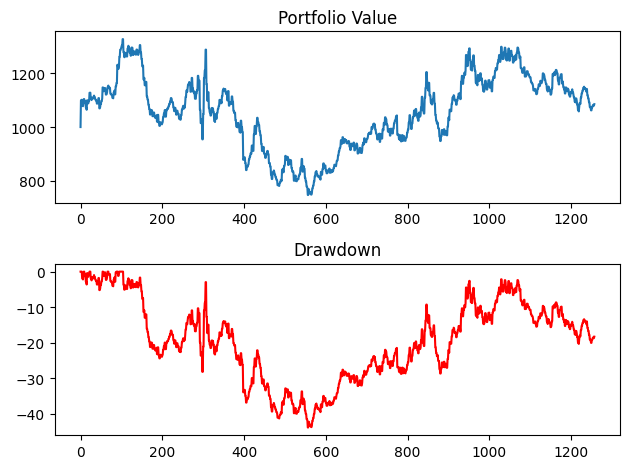

In [25]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise, every_day = Testing_signals.compounding()